# Calculating the input that maximizes a particular neuron


The idea is to train a neural network for an image classification problem (eg. https://keras.io/examples/vision/mnist_convnet/) or to use a pre-trained neural network (eg. MobilNetv2 from https://keras.io/examples/vision/mnist_convnet/). The choose and output neuron and find an input image that maximizes the output of this neuron.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Metric
import numpy as np
import re
import matplotlib.pyplot as plt

## Modeling the problem

In order to solve this task, we will try to define it as an optimization problem


### 1. Defining involved variables and functions

Then we will define our image input as a multidimensional array:

$$\vec{x} \in \mathbb{R}^{H \times W \times C}$$

where $H$ is the image height, $W$ is the image weight and $C$ is the number of channels of the image.

Also we can define our model as a multivariate function that receives an element $\vec{x}$ as input and as output the $m$ classes probabilities for the given image.

$$
\begin{array}{ccc}
  \textbf{md} & : & \mathbb{R}^{H \times W \times C} & \longrightarrow & \mathbb{R}^{1 \times m} \\
  &  & \vec{x} & \mapsto & \text{model.predict}(\vec{x})
\end{array}
$$

Then, as we are interested in a particular neuron $j$ output, we can apply a single function that lets only the interest output neuron survive the process and retreive a single number instead of a probabilities vector:

Let $\mathbf{e}^{(j)} \in \mathbb{R}^n$ be the vector defined by

$$
\mathbf{e}^{(j)} = (e_1, e_2, \ldots, e_n), \quad \text{where} \quad
e_i =
\begin{cases}
1 & \text{if } i = j \\
0 & \text{if } i \neq j
\end{cases}
$$

Then define the function $f^{(j)}$ as:

$$
\begin{array}{ccc}
  f^{(j)} & : & \mathbb{R}^{1 \times m} & \longrightarrow & \mathbb{R} \\
  &  & \vec{p} & \mapsto & \vec{p} \cdot \mathbf{e}^{(j)}
\end{array}
$$

With all this schema, we can define the output of a neuron $j$ given an specific sample $\vec{x}$ as:

$$\text{out}_j(\vec{x}) = f^{(j)}(\textbf{md}(\vec{x}))$$

Having this, the idea is to define a function $L$ to minimize that depends on $\text{out}_j$ in order to apply gradient descent. By the momment we won't define this function, we will see how we can get gradients for $\vec{x}$ input with the schema defined:

$$L = g(\text{out}_j(\vec{x}))$$

$$\frac{\partial L}{\partial \vec{x}} = \frac{\partial g}{\partial \text{out}_j} \cdot \frac{\partial \text{out}_j}{\partial \vec{x}} = \frac{\partial g}{\partial \text{out}_j} \cdot \frac{\partial f^{(j)}(\textbf{md}(\vec{x}))}{\partial \vec{x}}
$$

Given that $ f^{(j)}(\vec{p}) = \vec{p} \cdot \mathbf{e}^{(j)} $, and $ \vec{p} = \textbf{md}(\vec{x}) $, we apply the chain rule again:

$$\frac{\partial f^{(j)}(\textbf{md}(\vec{x}))}{\partial \vec{x}} = \frac{\partial f^{(j)}}{\partial \vec{p}} \cdot \frac{\partial \vec{p}}{\partial \vec{x}} = \mathbf{e}^{(j)} \cdot \frac{\partial \textbf{md}(\vec{x})}{\partial \vec{x}}
$$

So the final gradient becomes:

$$\frac{\partial L}{\partial \vec{x}} = \frac{\partial g}{\partial \text{out}_j} \cdot \mathbf{e}^{(j)} \cdot \frac{\partial \textbf{md}(\vec{x})}{\partial \vec{x}}
$$

With this last result, we may see a potential challenge, that is trying to compute the gradient of the base model againts the input ($\frac{\partial \textbf{md}(\vec{x})}{\partial \vec{x}}$). In order to solve this using backpropagation (An efficient technique to compute weight gradients in a neuronal network), we transform our problem so that we can interpret the input as weights of a network.


#### Input vector as a NN weights

We can imagine a neuronal network as the following:

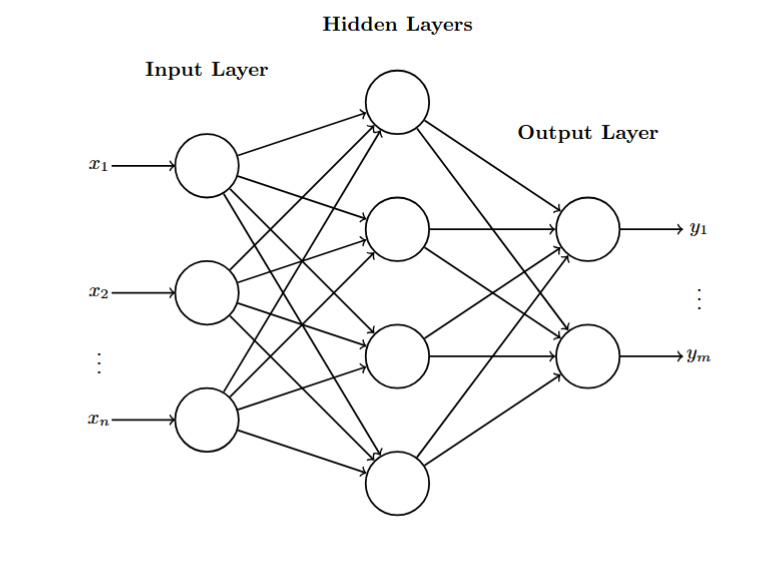

In this scenario, we can make an slight modification to the net so that we can make an intermediate layer between the output and the first hidden layer so that has 1 to 1 relationship where the weights in this layers. In order to have an equivalent model, we will set that the new neuronal network has as input the vector full of ones $\vec{\textbf{1}}$ and the activation function of this layer will be $h(x) = x$. The following diagram shows this new schema:

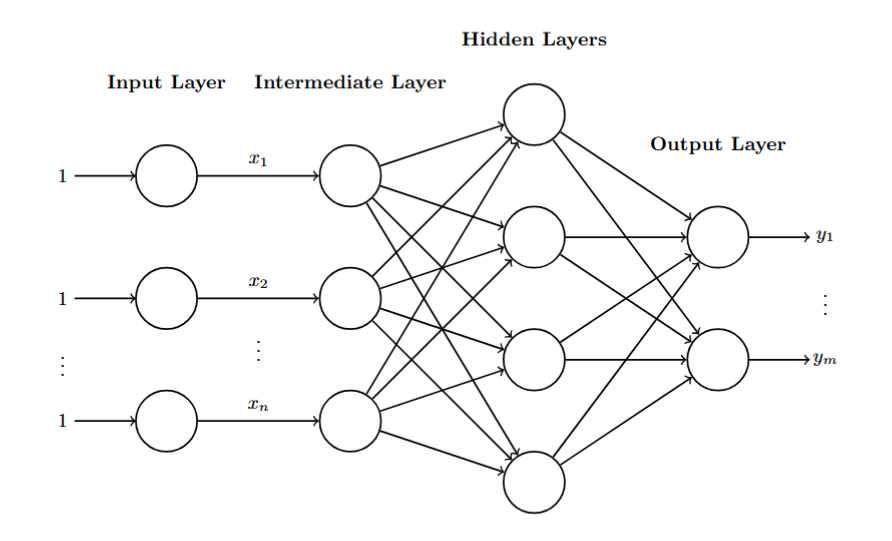

In this scenario we must have the following considerations:

1. As we can interpret the inputs as updatable parameters that we can change to optimize, we can use the different frameworks like Keras or Torch to achieve this task.

2. As we just one to update the params related to the output, we must freeze the weight params of the initial net in order to keep the equivalent model design.

3. When training this new model, we will use only the ones input in the new net as it fully activates the weights in the intermediate net.

4. This model will be independent of the activation as it only relates the schema that makes easier to find the gradients using the existing tools


### 2. Defining possible functions to minimize

As we can maximize the output, we have different ways to make this process (For this, we will remark that all the functions that are proposed must be differentiable to avoid problems):

1. $L(x) = -x$

  This is the most clear scenario for this process, we want to maximize the output then we can just minimize the negative version of the output.

2. $L(x) = \frac{1}{x}$

  In this scenario, we will take advantage of the asympotic behaviour of the function. Here, as x is larger, the function starts to decrease and be near the value zero. In our case that our outputs are probabilities, as the probability related to a neuron is near to zero, the value of this function is really high; while if it is close to 1 (The value we want to achieve), the function will be near to one.

  The advantage that we get to this function, is that we will never has as value the zero, avoiding situations where gradients vanish. However, when $x$ values are near to zero, the function values are to high, leading to possible numerical issues when computing gradients.

3. $L(x) = e^{-x}$

  This function will have a decreasing behaviour as the input increases. However (And as an important difference before the previous ones). On the interval for x between 0 and 1, the function never encounters a zero or a infinite.

In [2]:
def L1(y_true, y_pred):
    return tf.math.negative(y_pred)

def L2(y_true, y_pred):
  return tf.math.reciprocal(y_pred)

def L3(y_true, y_pred):
  return tf.math.exp(tf.math.negative(y_pred))

Now let's try to make a more interesting task. Let's attempt to maximize the output while we use the less number of input values on. In order to do this, we will add a new component to penalize the number of input weights that are turned on.

then we can take the previous $L(x)$ functions and add the penalization (In this case, we can use the norm of the flatten version of the weights of the intermediate layer). Then we will define the function $L_{less}(x)$ as:

$$L_{less}(x) = L(\textbf{out}_j(x)) + \lambda \cdot ||x||$$

In this scenario, lambda and becomes one of the model params (If lambda is equal top 0, we will have an equivalent model for the previous task)

In [3]:
def L_less(model, L_fun, lambda_ = 0.01):
  def loss(y_true, y_pred):
    pattern = re.compile(r"one_to_one_layer_?\d*")
    matching_layers = [layer for layer in model.layers if pattern.fullmatch(layer.name)]
    x_values = matching_layers[0].w
    penalty = tf.reduce_sum(tf.square(x_values))
    return L_fun(y_true,y_pred) + lambda_ * penalty
  return loss

## Applying the optimization task idea

In [4]:
class OneToOneLayer(Layer):
    def __init__(self, initializer=None, weight_name="one_to_one_weights", **kwargs):
        super(OneToOneLayer, self).__init__(**kwargs)
        self._raw_initializer = initializer
        self.initializer = None
        self.weight_name = weight_name

    def build(self, input_shape):
        weight_shape = input_shape[1:]

        # Default to zeros if no initializer was specified
        if self._raw_initializer is None:
            self.initializer = tf.keras.initializers.Zeros()
        elif isinstance(self._raw_initializer, np.ndarray):
            if self._raw_initializer.shape != tuple(weight_shape):
                raise ValueError(
                    f"Initializer shape {self._raw_initializer.shape} does not match weight shape {weight_shape}"
                )
            self.initializer = tf.constant_initializer(self._raw_initializer)
        else:
            self.initializer = tf.keras.initializers.get(self._raw_initializer)

        self.w = self.add_weight(
            shape=weight_shape,
            initializer=self.initializer,
            trainable=True,
            name=self.weight_name
        )

    def call(self, inputs):
        return inputs * self.w

class CollapseToIndexNeuron(Layer):
    def __init__(self, index, **kwargs):
        super(CollapseToIndexNeuron, self).__init__(**kwargs)
        self.index = index
        self.e_vector = None

    def build(self, input_shape):
        vector_length = input_shape[-1]
        e = np.zeros(vector_length, dtype=np.float32)
        e[self.index] = 1.0
        self.e_vector = tf.constant(e)

    def call(self, inputs):
        return tf.reduce_sum(inputs * self.e_vector, axis=-1)

import tensorflow as tf

class OutputOnFixedInput(Metric):
    def __init__(self, model, fixed_input, name="output_on_fixed_input", **kwargs):
        super().__init__(name=name, **kwargs)
        self.model = model
        self.fixed_input = fixed_input
        self.output_value = self.add_weight(name="output_value", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        output = self.model(self.fixed_input, training=False)
        val = tf.reduce_mean(output)
        self.output_value.assign(val)

    def result(self):
        return self.output_value

    def reset_states(self):
        self.output_value.assign(0.0)


In [5]:
def build_equivalent_model(base_model, target_neuron=0):
    base_model.trainable = False

    collapse_layer = CollapseToIndexNeuron(index=target_neuron)
    collapse_layer.trainable = False

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=base_model.input_shape[1:]),
        OneToOneLayer(weight_name = "inputs_layer"),
        base_model,
        collapse_layer
    ])

    return model

Now with this functional based strategy, we can test each of the scenarios using a image classification model.

## Testing over real models

### The MNIST model

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')],
        name = "MNIST")

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=0.1)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7689 - loss: 0.7477 - val_accuracy: 0.9782 - val_loss: 0.0816
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9640 - loss: 0.1208 - val_accuracy: 0.9853 - val_loss: 0.0579
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9736 - loss: 0.0880 - val_accuracy: 0.9848 - val_loss: 0.0502
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9773 - loss: 0.0744 - val_accuracy: 0.9877 - val_loss: 0.0440
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9796 - loss: 0.0660 - val_accuracy: 0.9898 - val_loss: 0.0393
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9815 - loss: 0.0589 - val_accuracy: 0.9905 - val_loss: 0.0358
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9834 - loss: 0.0544 - val_accuracy: 0.9910 - val_loss: 0.0330
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9836 - loss: 0.0496 - val_accuracy: 0

In [9]:
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.025855502113699913
Test accuracy: 0.991100013256073


Now with this trained model, we will try to see the image that maximizes the output with each one of them

In [10]:
def train_equivalent(base_model, target_neuron = 0, loss_fun = L1, epochs = 500, lr = 0.5, verbose = True):
  target_model = build_equivalent_model(base_model, target_neuron=target_neuron)
  input_shape = base_model.input_shape
  input_default = tf.ones((1, *input_shape[1:]))
  dummy_labels = tf.ones((1,))

  metric = OutputOnFixedInput(target_model, input_default)

  target_model.compile(
      optimizer=SGD(learning_rate=lr),
      loss=loss_fun,
      metrics=[metric]
  )

  history = target_model.fit(input_default, dummy_labels, epochs=epochs, verbose = 0)
  if verbose:
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.subplot(1,2,2)
    plt.plot(history.history['output_on_fixed_input'])
    plt.title('Output on fixed input')
    plt.xlabel('Epochs')
    plt.ylabel(f'Neuron {target_neuron} output')
    plt.show()
  else:
    print(f"Neuron {target_neuron} final output: {history.history['output_on_fixed_input'][-1]}")
  return target_model

We test for example with neuron 1 (Associated to number one output in MNIST)

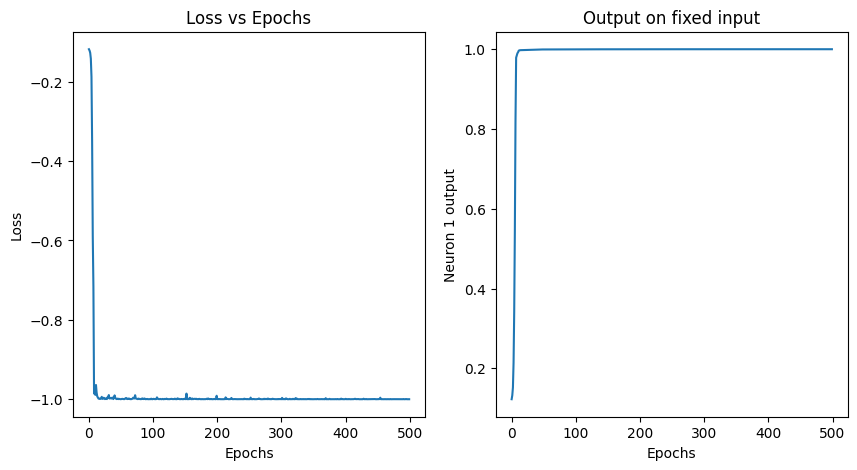

In [11]:
i = 1
model_target_i = train_equivalent(model, target_neuron = i, loss_fun = L1, epochs = 500, lr = 0.5)

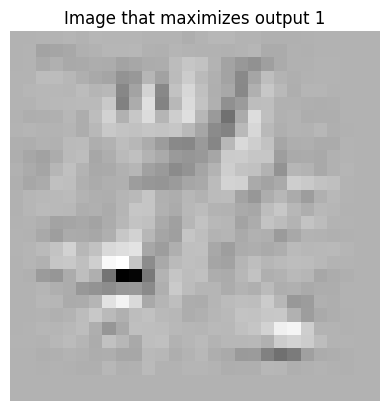

In [12]:
pattern = re.compile(r"one_to_one_layer_?\d*")

matching_layers = [layer for layer in model_target_i.layers if pattern.fullmatch(layer.name)]

for layer in matching_layers:
    l = np.array(layer.get_weights()).squeeze()
    plt.imshow(l, cmap='gray')
    plt.title(f'Image that maximizes output {i}')
    plt.axis('off')
    plt.show()

Now we will make a function that given just the function to minimize, gets the image of the using the base functions (L1, L2 and L3)

In [13]:
def check_all_MNIST_neurons(base_model, L_fun = L1, epochs = 500, lr = 0.5):
  pattern = re.compile(r"one_to_one_layer_?\d*")
  results = []
  for i in range(10):
    model_target_i = train_equivalent(base_model, target_neuron = i, loss_fun = L_fun, epochs = epochs, lr = lr, verbose = False)
    matching_layers = [layer for layer in model_target_i.layers if pattern.fullmatch(layer.name)]
    for layer in matching_layers:
        l = np.array(layer.get_weights()).squeeze()
        results.append(l)
  return results

def plot_images(images, sup_title):
  fig, axs = plt.subplots(2, 5, figsize=(12,5))
  fig.suptitle(sup_title)
  for i, ax in enumerate(axs.flat):
      ax.imshow(images[i], cmap='gray')
      ax.set_title(f'Max neuron {i}')
      ax.axis('off')
  plt.show()

In [16]:
print('Function L(x) = -x')
L1_data = check_all_MNIST_neurons(model, L_fun = L1, epochs = 500, lr = 0.6)
print('\nFunction L(x) = 1/x')
L2_data = check_all_MNIST_neurons(model, L_fun = L2, epochs = 600, lr = 0.006)
print('\nFunction L(x) = exp(-x)')
L3_data = check_all_MNIST_neurons(model, L_fun = L3, epochs = 500, lr = 0.6)

Function L(x) = -x
Neuron 0 final output: 0.9998831748962402
Neuron 1 final output: 0.9999833106994629
Neuron 2 final output: 0.9999803304672241
Neuron 3 final output: 0.9999613761901855
Neuron 4 final output: 0.9999749660491943
Neuron 5 final output: 0.9999864101409912
Neuron 6 final output: 0.999966025352478
Neuron 7 final output: 0.9999459981918335
Neuron 8 final output: 0.9999428987503052
Neuron 9 final output: 0.9998965263366699

Function L(x) = 1/x
Neuron 0 final output: 0.9718629717826843
Neuron 1 final output: 0.989439070224762
Neuron 2 final output: 0.9944730401039124
Neuron 3 final output: 0.9923237562179565
Neuron 4 final output: 0.9902172088623047
Neuron 5 final output: 0.9970346689224243
Neuron 6 final output: nan
Neuron 7 final output: 0.9888822436332703
Neuron 8 final output: 0.9755343198776245
Neuron 9 final output: 0.9646459817886353

Function L(x) = exp(-x)
Neuron 0 final output: 0.9993934631347656
Neuron 1 final output: 0.9998152852058411
Neuron 2 final output: 0.999

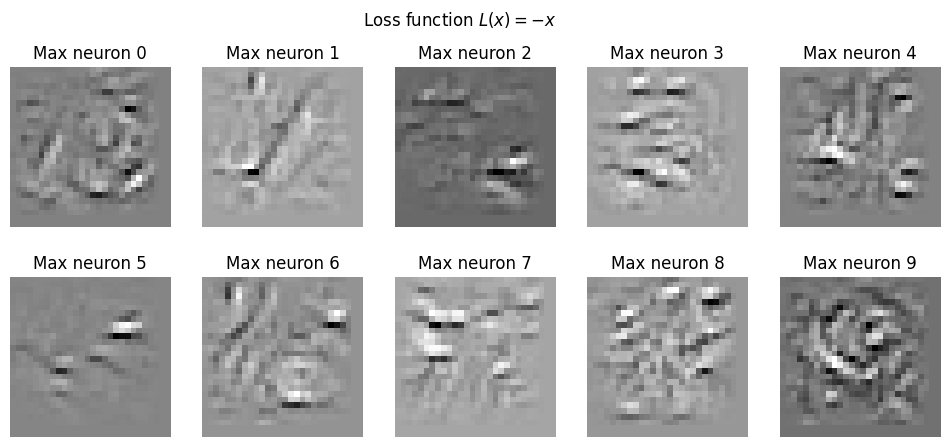

In [17]:
plot_images(L1_data, 'Loss function $L(x) = -x$')

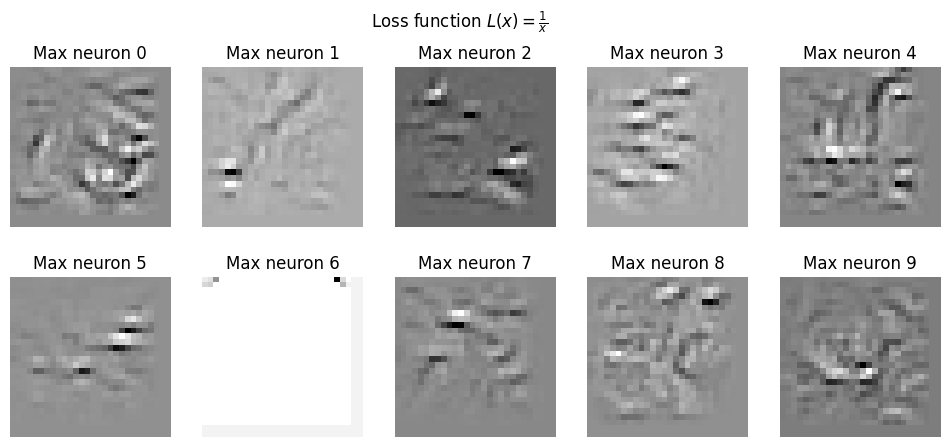

In [18]:
plot_images(L2_data, 'Loss function $L(x) = \\frac{1}{x}$')

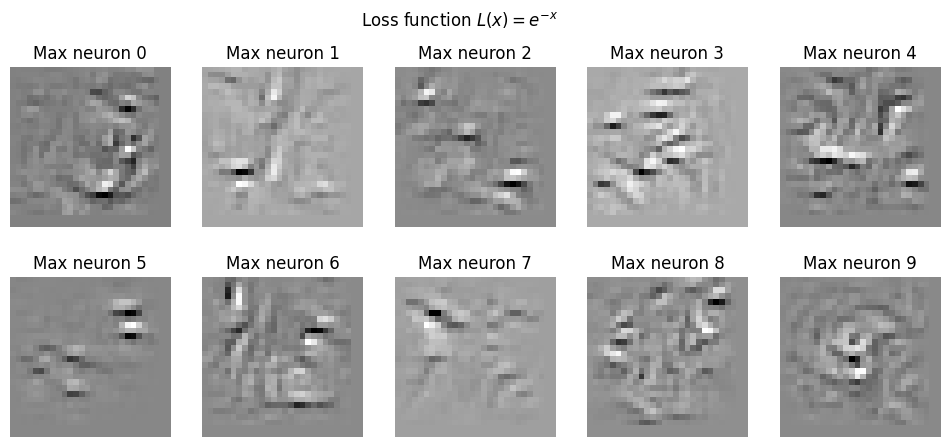

In [19]:
plot_images(L3_data, 'Loss function $L(x) = e^{-x}$')

Now we will make this same exercise using the composed function $L_{less}$ using the function $L_3$ as it shows fast convergence and does not have negative values.

In [20]:
def train_equivalent_L_Less(base_model, target_neuron = 0, loss_fun = L1, epochs = 500, lr = 0.5, lambda_ = 0.8, verbose = True):
  target_model = build_equivalent_model(base_model, target_neuron=target_neuron)
  input_shape = base_model.input_shape
  input_default = tf.ones((1, *input_shape[1:]))
  dummy_labels = tf.ones((1,))

  metric = OutputOnFixedInput(target_model, input_default)

  target_model.compile(
      optimizer=SGD(learning_rate=lr),
      loss=L_less(target_model,loss_fun,lambda_ = lambda_),
      metrics=[metric]
  )
  history = target_model.fit(input_default, dummy_labels, epochs=epochs, verbose = 0)
  if verbose:
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.subplot(1,2,2)
    plt.plot(history.history['output_on_fixed_input'])
    plt.title('Output on fixed input')
    plt.xlabel('Epochs')
    plt.ylabel(f'Neuron {target_neuron} output')
    plt.show()
  else:
    print(f"Neuron {target_neuron} final output: {history.history['output_on_fixed_input'][-1]}")
  return target_model

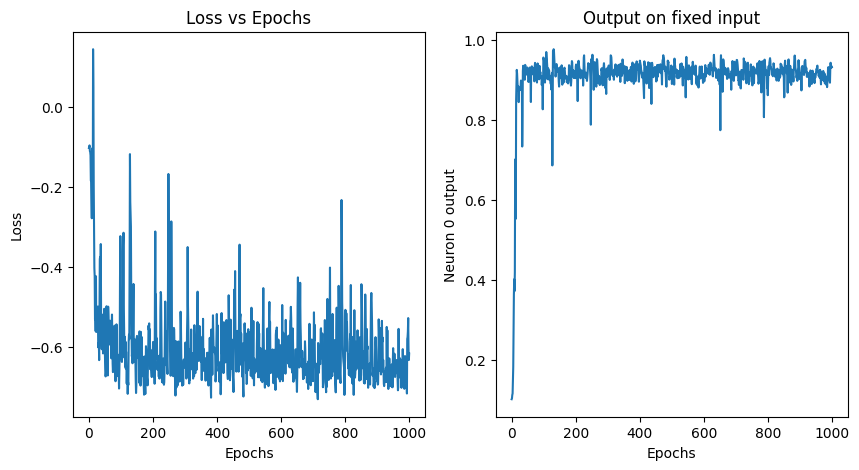

In [21]:
i = 0
model_L_less_v1 = train_equivalent_L_Less(model, target_neuron = i, loss_fun = L1, epochs = 1000, lr = 0.6, lambda_ = 0.1, verbose = True)

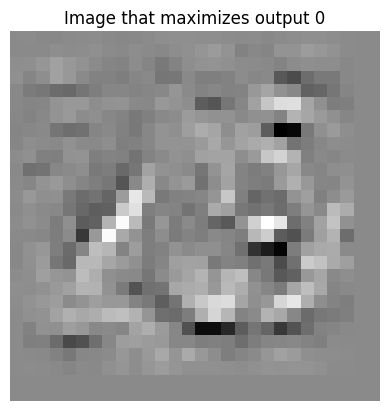

In [22]:
pattern = re.compile(r"one_to_one_layer_?\d*")

matching_layers = [layer for layer in model_L_less_v1.layers if pattern.fullmatch(layer.name)]

for layer in matching_layers:
    l = np.array(layer.get_weights()).squeeze()
    plt.imshow(l, cmap='gray')
    plt.title(f'Image that maximizes output {i}')
    plt.axis('off')
    plt.show()

Now we will see this behaviour over the three loss functions

In [23]:
def check_all_MNIST_neurons_L_less(base_model, L_fun = L1, epochs = 500, lr = 0.5, lambda_ = 0.1):
  pattern = re.compile(r"one_to_one_layer_?\d*")
  results = []
  for i in range(10):
    model_target_i = train_equivalent_L_Less(base_model, target_neuron = i, loss_fun = L_fun, epochs = epochs, lr = lr, lambda_ = 0.1, verbose = False)
    matching_layers = [layer for layer in model_target_i.layers if pattern.fullmatch(layer.name)]
    for layer in matching_layers:
        l = np.array(layer.get_weights()).squeeze()
        results.append(l)
  return results

In [24]:
print('Function L(x) = -x')
L1_data_L_less = check_all_MNIST_neurons_L_less(model, L_fun = L1, epochs = 1000, lr = 0.6)
print('\nFunction L(x) = 1/x')
L2_data_L_less = check_all_MNIST_neurons_L_less(model, L_fun = L2, epochs = 1000, lr = 0.01)
print('\nFunction L(x) = exp(-x)')
L3_data_L_less = check_all_MNIST_neurons_L_less(model, L_fun = L3, epochs = 1000, lr = 0.6)

Function L(x) = -x
Neuron 0 final output: 0.9160178303718567
Neuron 1 final output: 0.9621058106422424
Neuron 2 final output: 0.9888507723808289
Neuron 3 final output: 0.9843855500221252
Neuron 4 final output: 0.9634524583816528
Neuron 5 final output: 0.9877447485923767
Neuron 6 final output: 0.9512146711349487
Neuron 7 final output: 0.9603003859519958
Neuron 8 final output: 0.922117292881012
Neuron 9 final output: 0.9075176119804382

Function L(x) = 1/x
Neuron 0 final output: 0.9248502254486084
Neuron 1 final output: 0.9609194993972778
Neuron 2 final output: 0.9708563685417175
Neuron 3 final output: 0.9749206304550171
Neuron 4 final output: 0.9579788446426392
Neuron 5 final output: 0.9851667284965515
Neuron 6 final output: 0.967568039894104
Neuron 7 final output: 0.9693405032157898
Neuron 8 final output: 0.9368597865104675
Neuron 9 final output: 0.9149692058563232

Function L(x) = exp(-x)
Neuron 0 final output: 0.764853835105896
Neuron 1 final output: 0.8768675923347473
Neuron 2 final

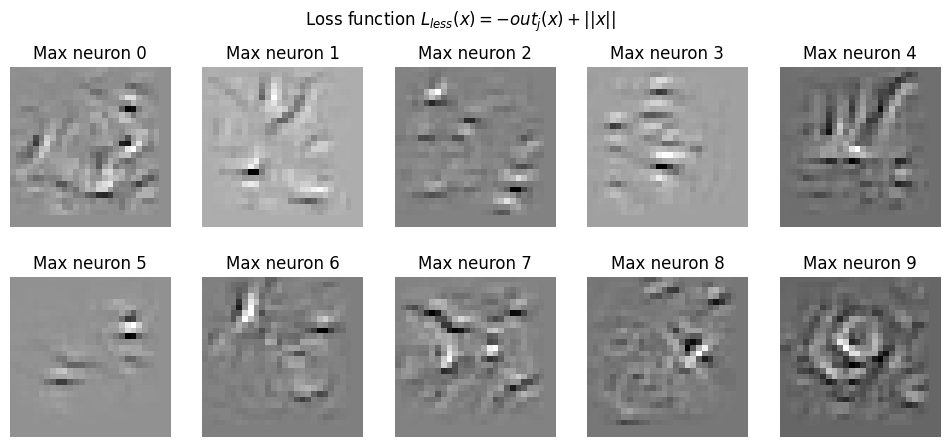

In [25]:
plot_images(L1_data_L_less, 'Loss function $L_{less}(x) = -out_j(x) + ||x||$')

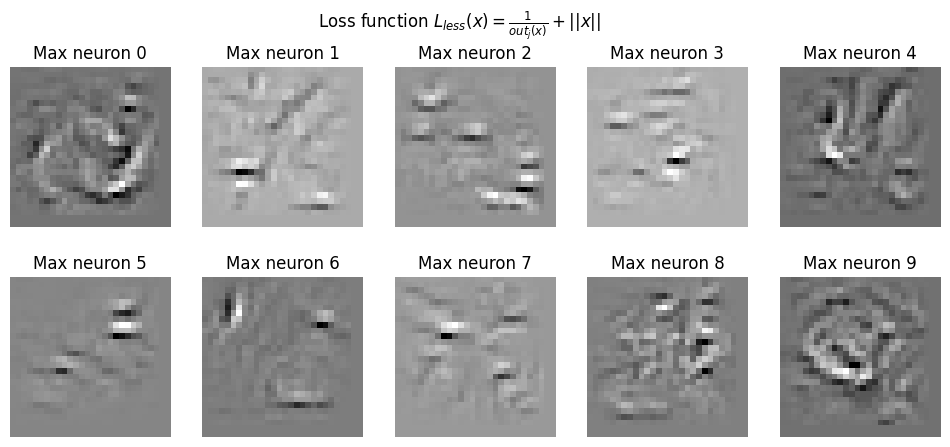

In [26]:
plot_images(L2_data_L_less, 'Loss function $L_{less}(x) = \\frac{1}{out_j(x)} + ||x||$')

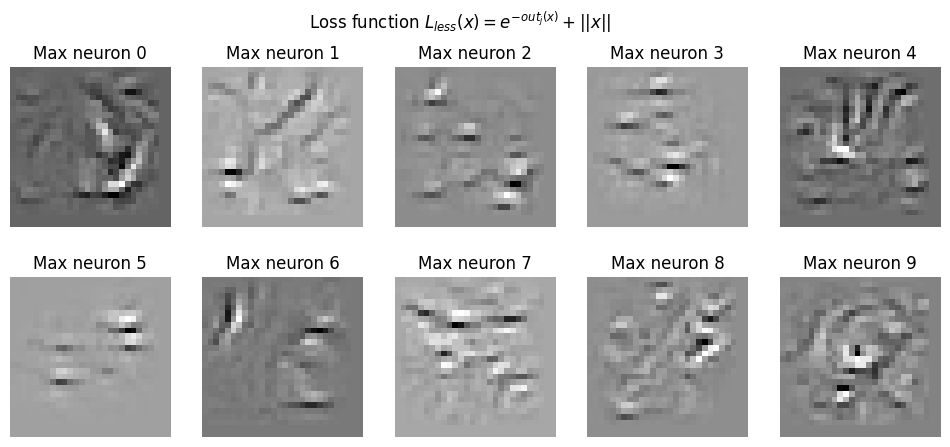

In [27]:
plot_images(L3_data_L_less, 'Loss function $L_{less}(x) = e^{-out_j(x)} + ||x||$')

Finally, we will check that the images received actually are related to tha class predicted by the base model (Just as an assurance procecure)

In [28]:
def check_results_over_base_model(data, base_model):
  for number, sample in enumerate(data):
    sample = np.expand_dims(sample, axis=0)
    s = base_model.predict(sample, verbose = 0).flatten()
    class_ = np.argmax(s)
    print(f'Max image for neuron {number} is classified in number {class_}')

In [29]:
print(f'Function L(x) = -x data results')
check_results_over_base_model(L1_data, model)
print(f'\nFunction L(x) = 1/x data results')
check_results_over_base_model(L2_data, model)
print(f'\nFunction L(x) = exp(-x) data results')
check_results_over_base_model(L3_data, model)

Function L(x) = -x data results
Max image for neuron 0 is classified in number 0
Max image for neuron 1 is classified in number 1
Max image for neuron 2 is classified in number 2
Max image for neuron 3 is classified in number 3
Max image for neuron 4 is classified in number 4
Max image for neuron 5 is classified in number 5
Max image for neuron 6 is classified in number 6
Max image for neuron 7 is classified in number 7
Max image for neuron 8 is classified in number 8
Max image for neuron 9 is classified in number 9

Function L(x) = 1/x data results
Max image for neuron 0 is classified in number 0
Max image for neuron 1 is classified in number 1
Max image for neuron 2 is classified in number 2
Max image for neuron 3 is classified in number 3
Max image for neuron 4 is classified in number 4
Max image for neuron 5 is classified in number 5
Max image for neuron 6 is classified in number 0
Max image for neuron 7 is classified in number 7
Max image for neuron 8 is classified in number 8
Max

In [30]:
print('Results using L_less with lambda = 0.1')
print(f'Function L(x) = -x data results')
check_results_over_base_model(L1_data_L_less, model)
print(f'\nFunction L(x) = 1/x data results')
check_results_over_base_model(L2_data_L_less, model)
print(f'\nFunction L(x) = exp(-x) data results')
check_results_over_base_model(L3_data_L_less, model)

Results using L_less with lambda = 0.1
Function L(x) = -x data results
Max image for neuron 0 is classified in number 0
Max image for neuron 1 is classified in number 1
Max image for neuron 2 is classified in number 2
Max image for neuron 3 is classified in number 3
Max image for neuron 4 is classified in number 4
Max image for neuron 5 is classified in number 5
Max image for neuron 6 is classified in number 6
Max image for neuron 7 is classified in number 7
Max image for neuron 8 is classified in number 8
Max image for neuron 9 is classified in number 9

Function L(x) = 1/x data results
Max image for neuron 0 is classified in number 0
Max image for neuron 1 is classified in number 1
Max image for neuron 2 is classified in number 2
Max image for neuron 3 is classified in number 3
Max image for neuron 4 is classified in number 4
Max image for neuron 5 is classified in number 5
Max image for neuron 6 is classified in number 6
Max image for neuron 7 is classified in number 7
Max image for